In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns
import os,sys
import helper_scripts as hs
from helper_scripts import effect_plot as EP

from helper_scripts import DimensionalReduction 

import yaml

Populating the interactive namespace from numpy and matplotlib


/Users/silas/miniconda3/lib/python3.6/site-packages/scikit_bio-0.5.5-py3.6-macosx-10.7-x86_64.egg/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [2]:
%run warm_figure_scripts.py

In [3]:


os.chdir('../data/Sequencing_C/')


config= yaml.load(open('config_analysis.yaml'))
Comparisons= list(config['Comparisons'].keys())

os.chdir('./Analysis/Analysis')




/Users/silas/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


# Define Group

In [4]:
SAVEPLOT=False
output_folder="../Figures"

In [5]:
order=[ 'ova\ntranspl.\nRT', 'ova\ntranspl.\n34°C'] 

group_colors= ['darkgrey','darkred']




Analysis_Name="TempOVA-t"

output_folder+=Analysis_Name



In [6]:
hs.plotting.plotting_Setup()






os.makedirs(output_folder,exist_ok=True)
SAVEPLOT=True



plt_params=dict(figurefolder=output_folder,
    formats=['.svg'],
    SAVEPLOT=SAVEPLOT)               ### SAVEPLOT

# Realab

In [7]:
data=pd.read_csv('data.tsv',index_col=0,sep='\t')
data= data.apply(hs.microbiota.normalize_row,axis=1)*100
metadata= load_metadata()
rename_metadata(data,metadata)



/Users/silas/Documents/GitHub/WarmMicrobiota/Mice_microbiota/notebooks/helper_scripts/Bubbleplots.py:144: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.subplot(111)


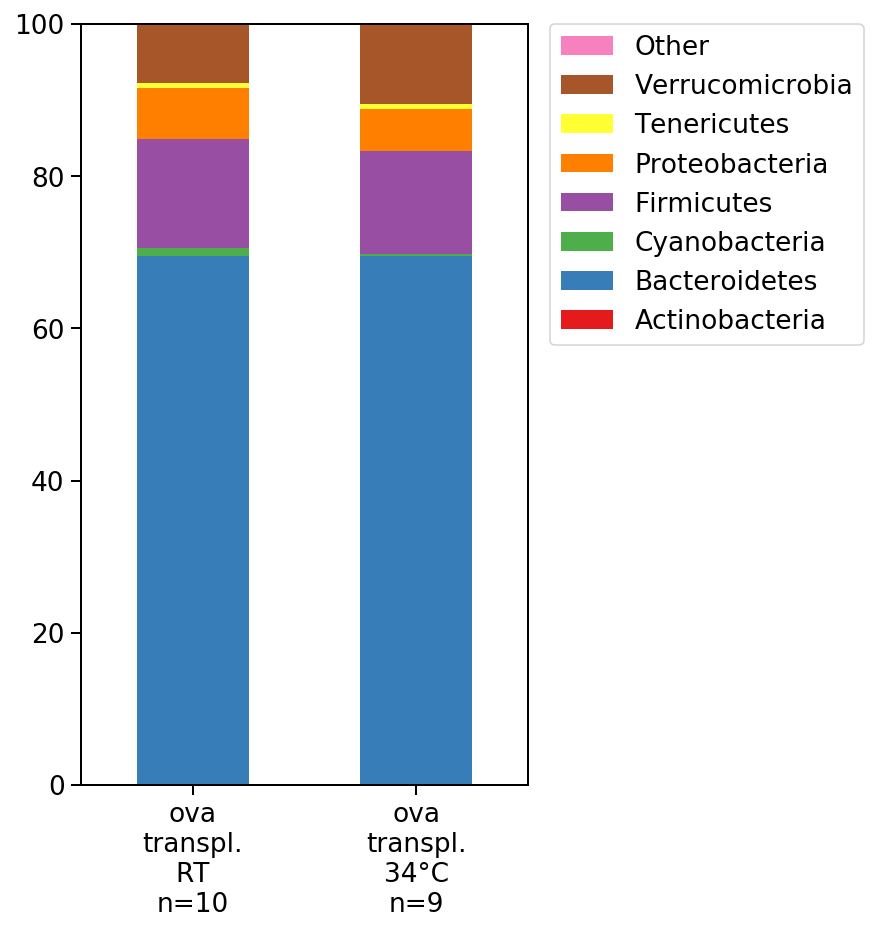

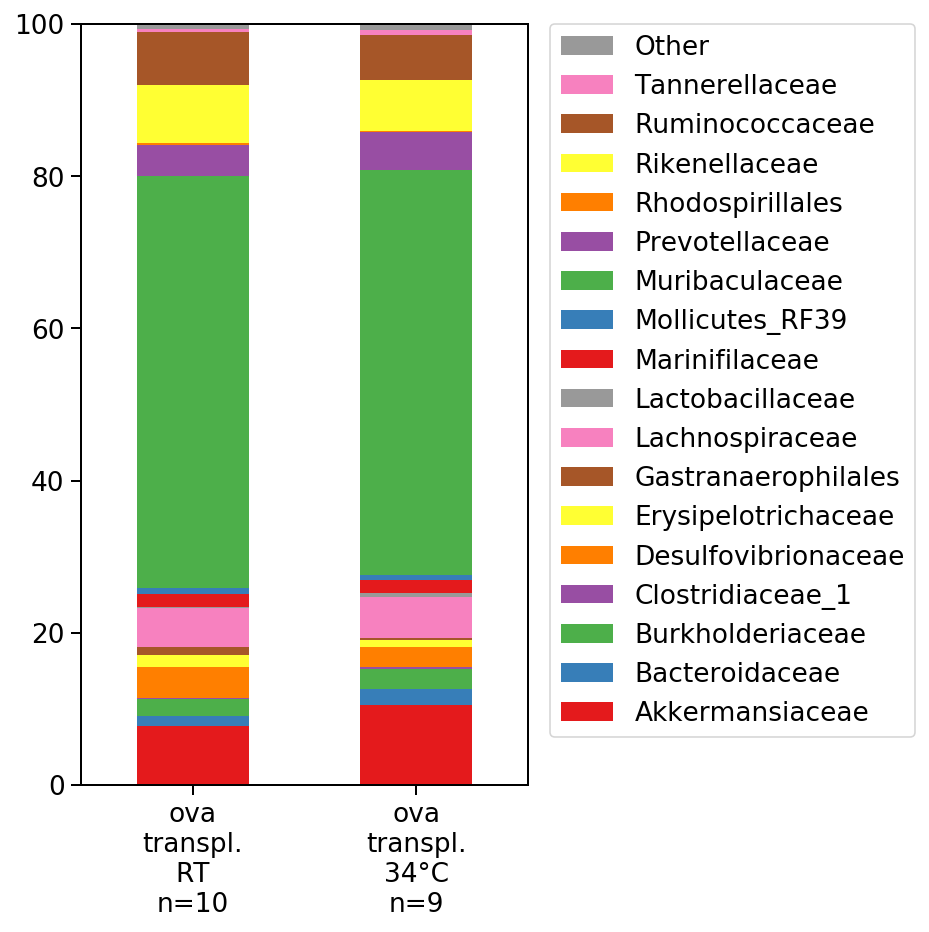

In [8]:
sns.set_palette('Set1',n_colors=18)
hs.bubble.MeanGroup_Barplot(data.groupby(Tax.ffill(axis=1).phylum,axis=1).sum(), 
                            metadata.Group,sp_keywords={'colorM':None},order=order, figsize=(4,7),
                            filtervalue=18)


hs.plotting.saveplot('Barplot_phylum',**plt_params)


sns.set_palette('Set1',n_colors=18)
hs.bubble.MeanGroup_Barplot(data.groupby(Tax.ffill(axis=1).family,axis=1).sum(), 
                            metadata.Group,sp_keywords={'colorM':None},order=order, figsize=(4,7),
                            filtervalue=18)


hs.plotting.saveplot('Barplot_family',**plt_params)

# Richness

In [9]:
OTU= pd.read_csv('../output/seqtab.tsv',index_col=0,sep='\t')
metadata= load_metadata()
rename_metadata(OTU,metadata)
OTU,metadata= take_subset(OTU,metadata,order)


rarified= pd.DataFrame(rarefaction(OTU.values),index=OTU.index,columns=OTU.columns) 

presence_absence = (rarified>0).astype(int)
R= pd.DataFrame()
R['Richness'] = presence_absence.sum(1)
R['Shannon']= rarified.apply(hs.microbiota.shannon,axis=1)
R['Chao1']= rarified.apply(skbio.diversity.alpha.chao1,axis=1)



Tree= skbio.tree.TreeNode.read('../taxonomy/otu_tree.nwk')
Tree= Tree.root_at_midpoint()

R['Faith index']= rarified.apply(skbio.diversity.alpha.faith_pd,axis=1,args=(rarified.columns,Tree))


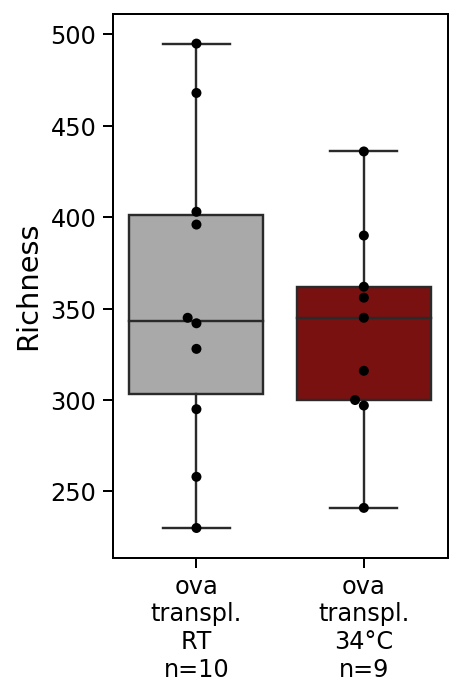

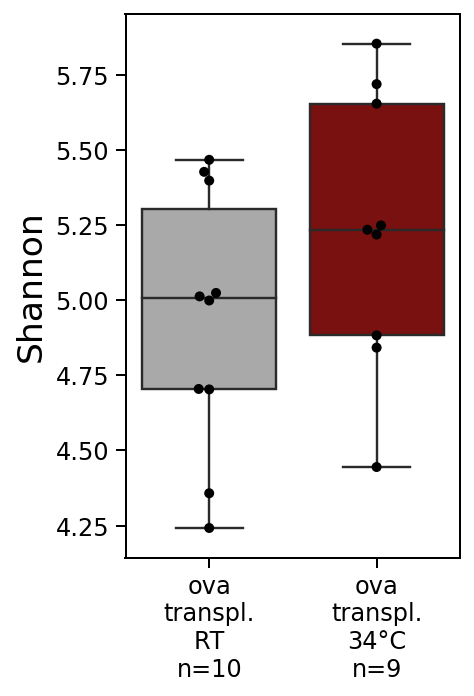

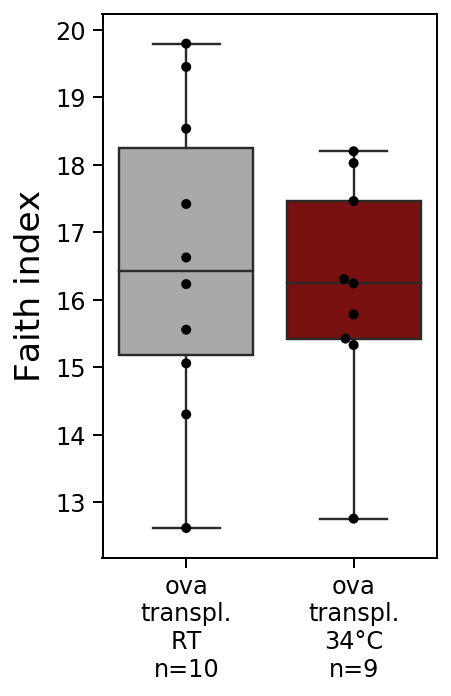

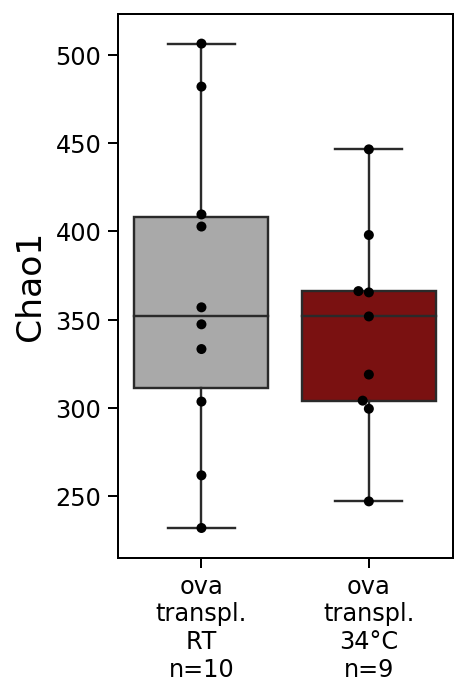

In [10]:
V=hs.Viewpoint(R,metadata.Group,order)
hs.plotting.plotting_Setup(font_scale=1.5)

sns.set_palette(group_colors)

for e in ['Richness','Shannon','Faith index','Chao1']:
    plt.figure(figsize=(3,5))
    
    ax=V.Boxplot(e)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    
    hs.plotting.saveplot(e,**plt_params)

# Aldex

In [11]:

aldex_file=f"Comparisons/{Analysis_Name}/stats_aldex.tsv"

Stats,data = load_aldex(aldex_file)
    
    
metadata= load_metadata()
data,metadata=take_subset(data,metadata)

#data= data.loc[metadata.index].copy()


rename_metadata(data,metadata)

# PCA

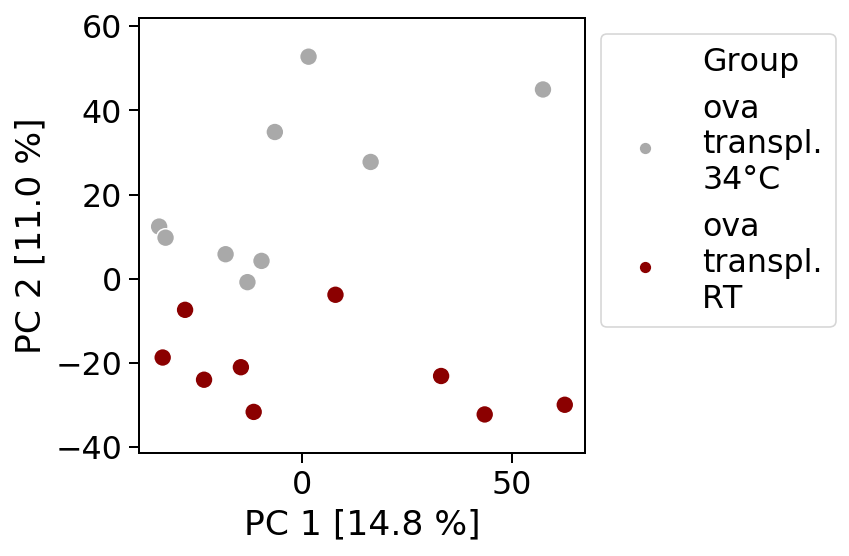

In [12]:

f= plt.figure(figsize=(4,4))

DR= DimensionalReduction.DimensionalReduction(data)
ax= DR.plot_Components_2D(hue=metadata.Group,palette=group_colors,s=80)

ax.legend(bbox_to_anchor=(1,1))


hs.plotting.saveplot('PCA',**plt_params)

## Heatmap

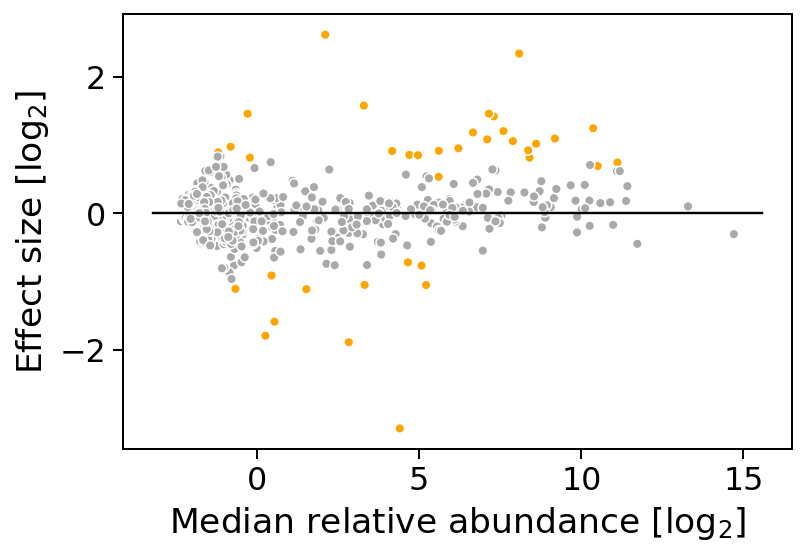

In [13]:
sig= Stats.index[(Stats['we.ep']<0.05)]


abundance_FC_plot(Stats,sig)
hs.plotting.saveplot('Effect_size_heatmap',**plt_params)

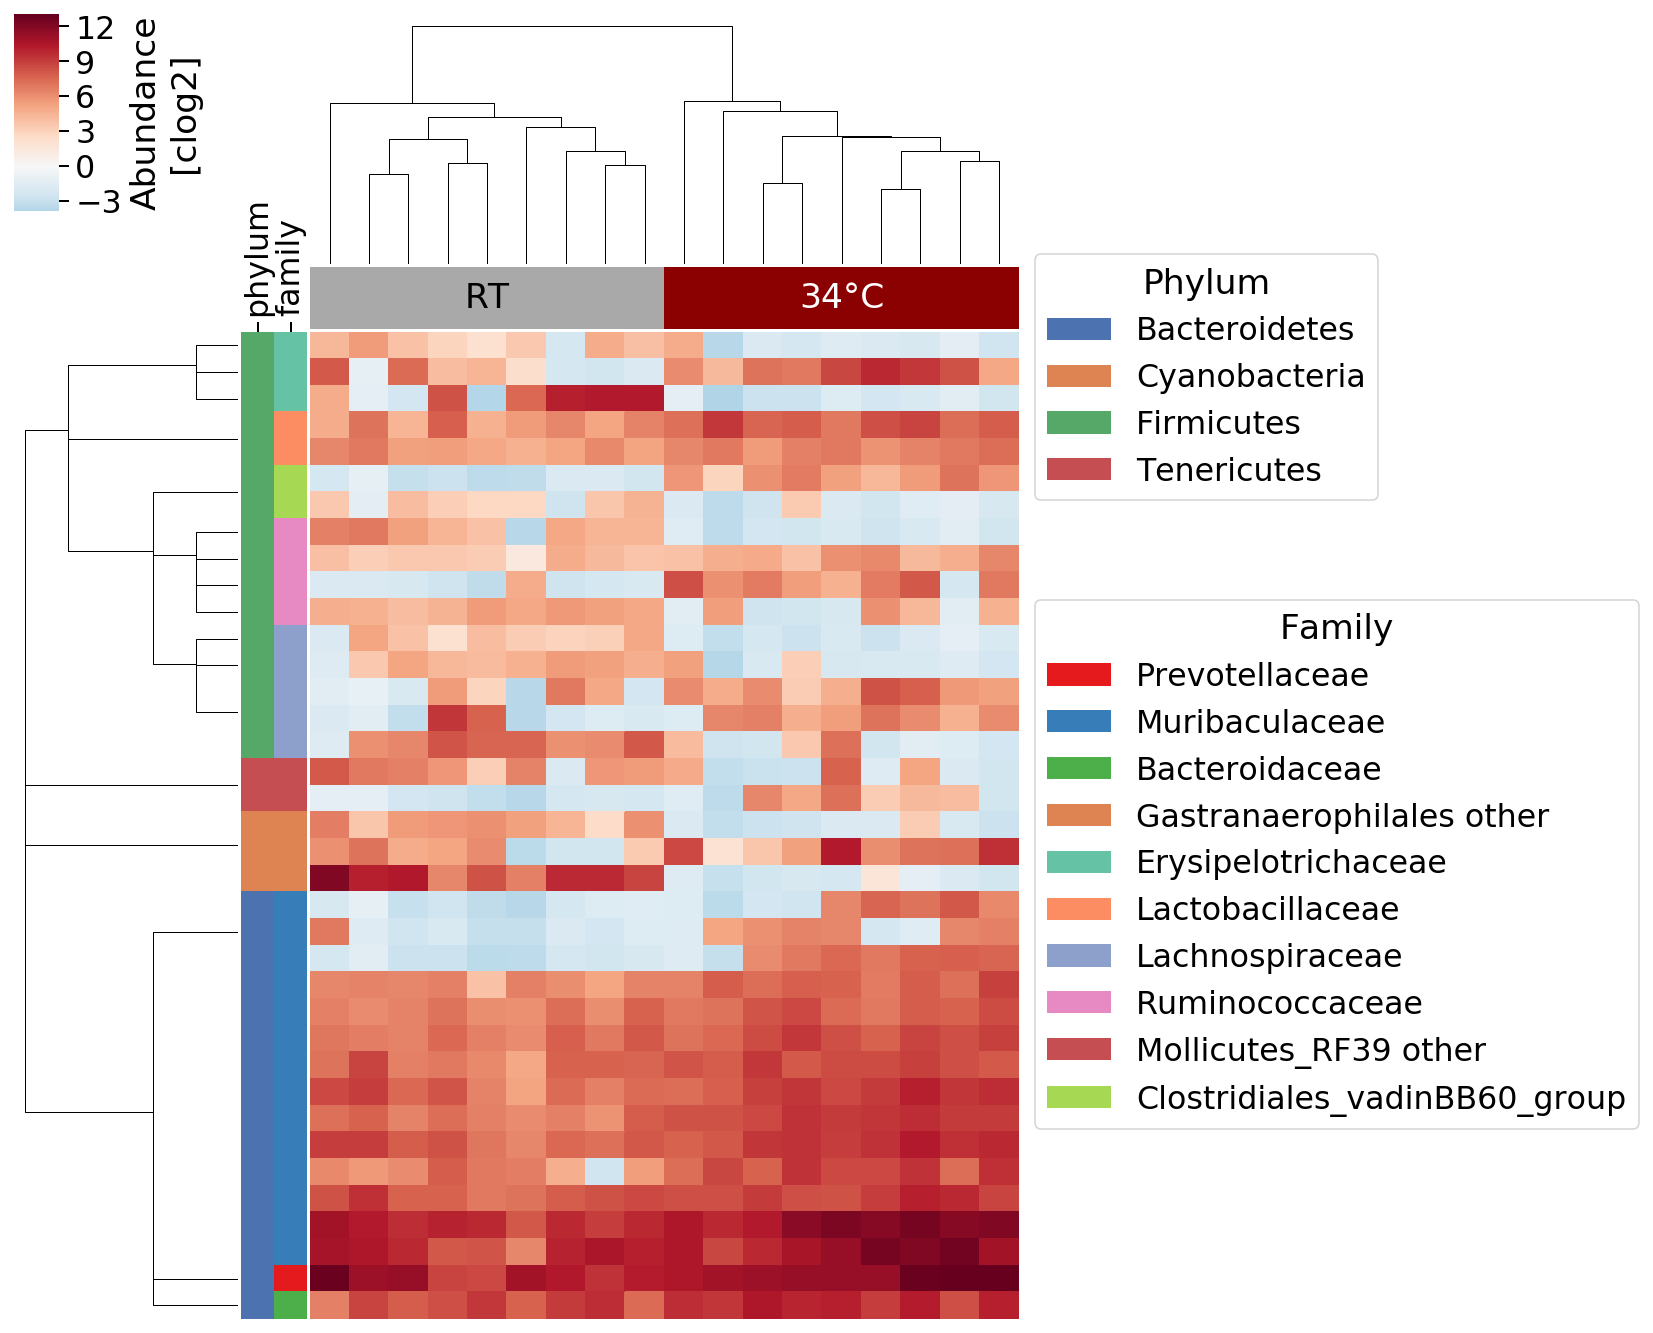

In [14]:


from helper_scripts import tree
OTU_tree = tree.load_tree('../taxonomy/otu_tree.nwk')


T= Tax.loc[sig].ffill(axis=1).copy()
T[Tax.loc[sig].isnull()]+=' other'

plt_data= data[sig].T.copy()



colors= metadata.Group.map(dict(zip(order,group_colors)))


def getcolor_map(labels,palette):
    return dict(zip(labels, sns.color_palette(palette,n_colors=len(labels))))

def map2colors(taxonomy,palette='deep'):
    return taxonomy.map(getcolor_map(taxonomy.unique(),palette))



row_colors= pd.DataFrame(index=T.index)
row_colors['phylum']= map2colors(T.phylum)
row_colors['family']= row_colors['phylum']

row_colors.loc[T.phylum=='Bacteroidetes','family']= map2colors(T.loc[T.phylum=='Bacteroidetes','family'],'Set1')
row_colors.loc[T.phylum=='Firmicutes','family']= map2colors(T.loc[T.phylum=='Firmicutes','family'],'Set2')




#linkage= tree.tree2linkage(OTU_tree,sig,'average') 
linkage= tree.taxonomy2linkage(T,species=sig)



cgi=sns.clustermap(plt_data,row_linkage=linkage, #row_cluster=False,
               cmap='RdBu_r',center=0, figsize=(9,12),
               col_colors=colors,
                   row_colors= row_colors,
                   yticklabels=False,#Labels.loc[plt_data.index],
                   xticklabels=False
              )

_ =cgi.cax.set_ylabel('Abundance\n[clog2]',fontdict={'fontsize':'medium'})


# Legend


f=plt.gcf()
def generate_legend(color_labels,**legend_kws):
    f=plt.gcf()
    ax= f.add_axes((0.5,0.5+np.random.rand()/100,0,0))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    for label,color in color_labels.iteritems():
        ax.bar(0, 0, color=color, label=label, linewidth=0)
        
    ax.legend(**legend_kws)
    
    return ax

color_labels= pd.Series(index=T.phylum.values,data=row_colors.phylum.values).drop_duplicates()
l1=generate_legend(color_labels,
                title='Phylum', loc="upper left", ncol=1, bbox_to_anchor=(0.9, 0.75), bbox_transform=f.transFigure)

#l1=generate_legend(color_labels,
#                title='Phylum', loc="upper left", ncol=4, bbox_to_anchor=(0.12, 0.12), bbox_transform=f.transFigure)

color_labels= pd.Series(index=T.family.values,data=row_colors.family.values).drop_duplicates()
l2= generate_legend(color_labels,
                title='Family', loc="upper left",ncol=1, bbox_to_anchor=(0.9, 0.55), bbox_transform=f.transFigure)


cgi.ax_row_colors.xaxis.tick_top()
cgi.ax_row_colors.set_xticklabels(cgi.ax_row_colors.get_xticklabels(),rotation=90)
cgi.ax_col_colors.set_yticks([])

# Group labels in col colors
axcc= cgi.ax_col_colors
axcc.text(0.25, 0.5, 'RT', horizontalalignment='center',
          verticalalignment='center', transform=axcc.transAxes)

axcc.text(0.75, 0.5, '34°C', horizontalalignment='center',color='white',
          verticalalignment='center', transform=axcc.transAxes)

## resize 

width_ratios= cgi.gs.get_width_ratios()
width_ratios[-1]/=1.5
cgi.gs.set_width_ratios(width_ratios)
cgi.gs.update()

if plt_params['SAVEPLOT']:
    cgi.savefig(os.path.join(output_folder,'heatmap.svg'))

# Boxplots

9

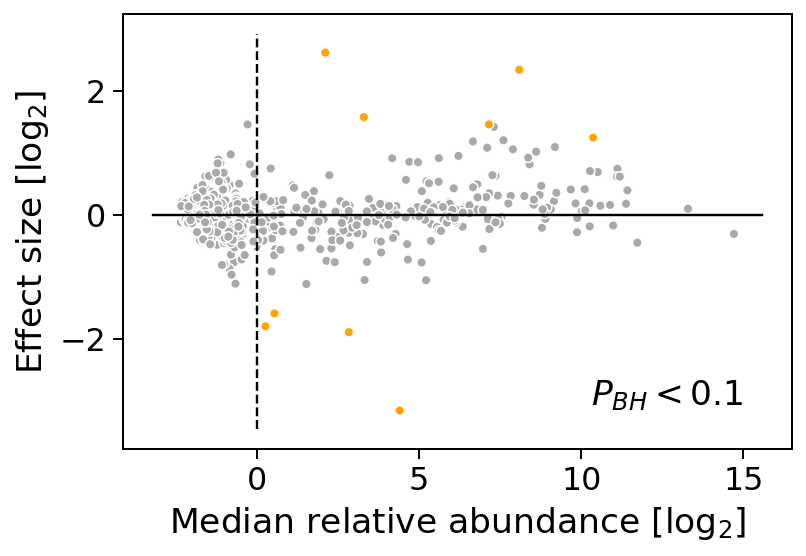

In [15]:
effect='effect'
ab_treshold=0
p_treshold = 0.1


sig= Effect_size_plot(Stats,p_treshold=p_treshold,ab_treshold=ab_treshold)


hs.plotting.saveplot('Effect_size_boxplots_OTU',**plt_params)
len(sig)

In [16]:
Stats.drop('label',axis=1).join(Tax).to_csv(f"{output_folder}/Stats_OTU.tsv",sep='\t')

In [17]:

Pairwise_Sig= Stats[['we.ep']].T.copy()

Pairwise_Sig.index= [tuple(order)]



V=hs.Viewpoint(data[sig],metadata.Group,order,Header_Description=Labels,
               Pairwise_Sig= Pairwise_Sig)
               

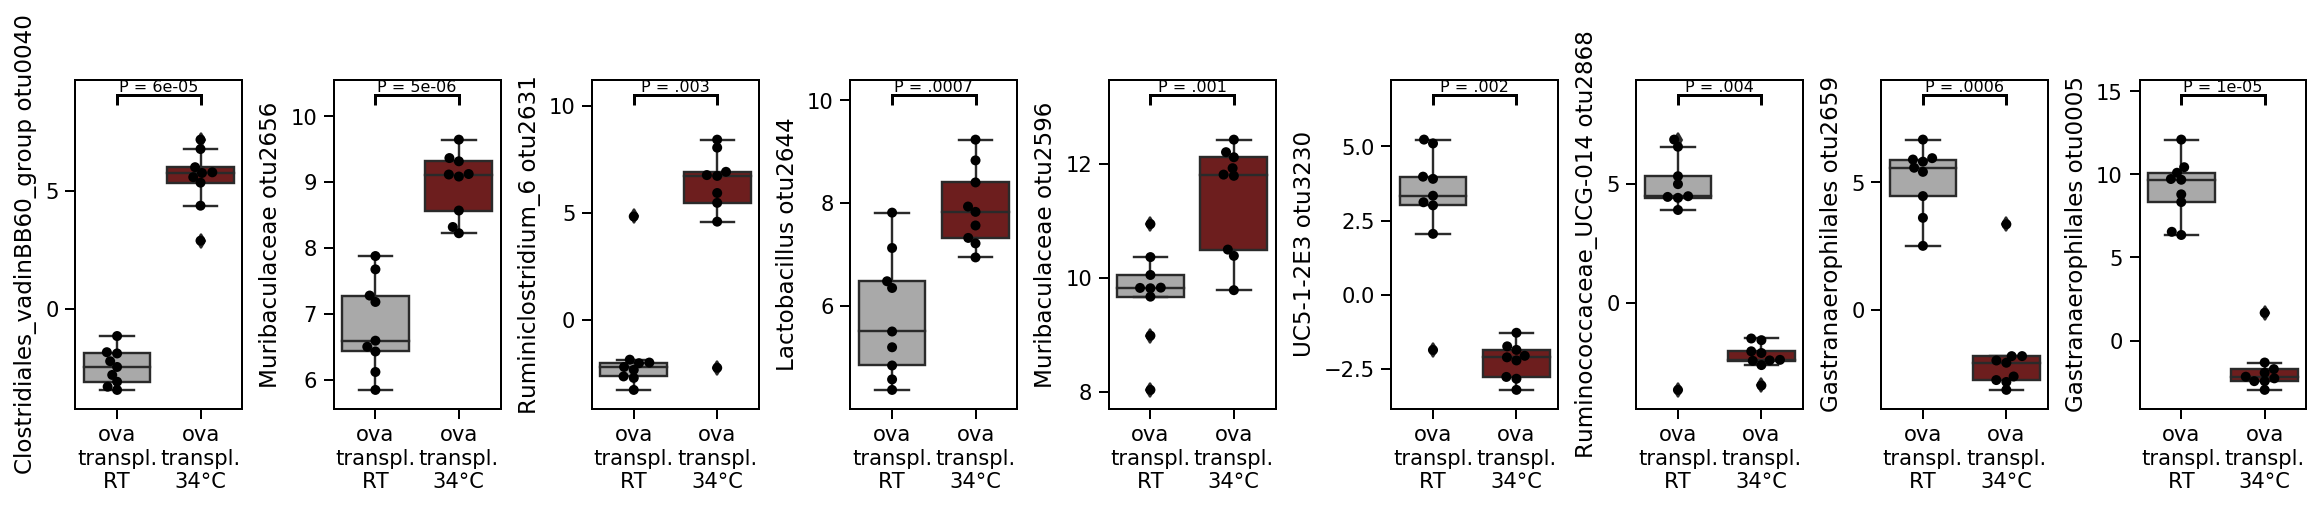

In [18]:
hs.plotting.plotting_Setup(font_scale=1.2)
sns.set_palette(group_colors,desat=0.75)


axe= multiplot(V,1,9,sig,figsize=(16,3.4),sharey=False,
pannel_letters=False,sig_labels_params={'font_size':8})
#plt.tight_layout(w_pad=0.1,h_pad=0.1)

for ax in axe:
    ax.set_xticklabels(order)

    
hs.plotting.saveplot('Boxplot_OTU',**plt_params)

## Genus

2

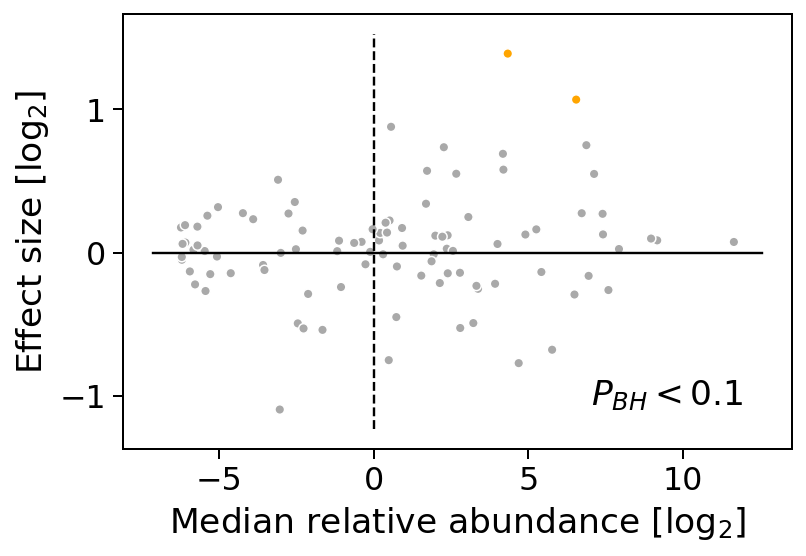

In [19]:

StatsG,G = load_aldex(f"../Analysis_genus/Comparisons/{Analysis_Name}/stats_aldex.tsv")
metadata= load_metadata()


rename_metadata(G,metadata)


StatsG.drop('label',axis=1).to_csv(f"{output_folder}/Stats_genus.tsv",sep='\t')

sigG=  Effect_size_plot(StatsG,p_treshold=p_treshold,ab_treshold=ab_treshold)


hs.plotting.saveplot('Effect_size_boxplots_Genus',**plt_params)
len(sigG)

In [20]:
sigG= (StatsG['we.eBH']<0.1)#&(StatsG['rab.all']>1)#&(StatsG[effect].abs()>1)

sigG = StatsG.loc[sigG].sort_values(effect,ascending=False).index
len(sigG)

2

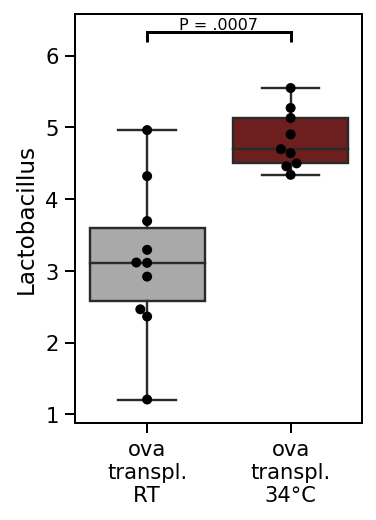

In [21]:
hs.plotting.plotting_Setup(font_scale=1.2)

sns.set_palette(group_colors,desat=0.75)

Pairwise_Sig= StatsG[['we.ep']].T.copy()
Pairwise_Sig.index= [tuple(order)]

VG=hs.Viewpoint(G[sigG],metadata.Group,order,
               Pairwise_Sig= Pairwise_Sig)



axe= multiplot(VG,1,1,sigG,figsize=(2.5,3.5),sharey=False,pannel_letters=False,sig_labels_params={'font_size':8})
#plt.tight_layout(w_pad=0.1,h_pad=0.1)

for ax in axe:
    ax.set_xticklabels(order)

    
hs.plotting.saveplot('Boxplot_Genus',**plt_params)

## Family

2

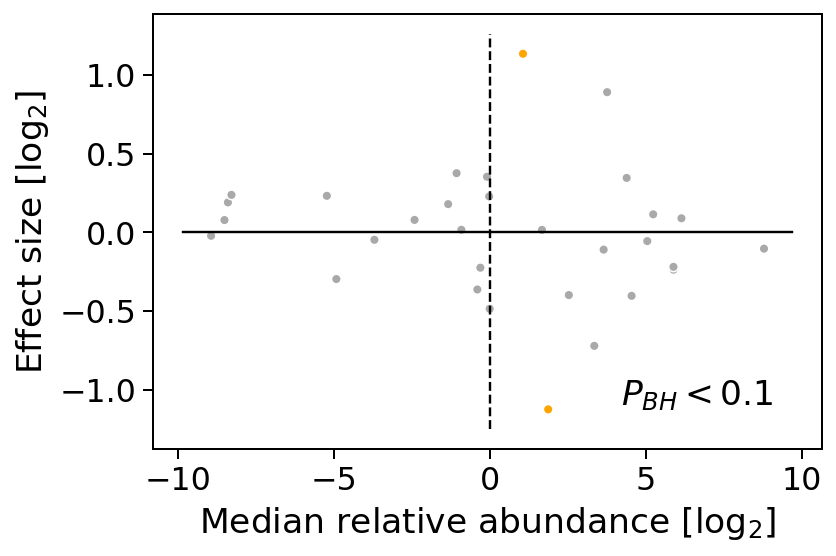

In [22]:

StatsF,F = load_aldex(f"../Analysis_family/Comparisons/{Analysis_Name}/stats_aldex.tsv")
metadata= load_metadata()


rename_metadata(F,metadata)


sigF= Effect_size_plot(StatsF,p_treshold=p_treshold,ab_treshold=ab_treshold)

StatsF.drop('label',axis=1).to_csv(f"{output_folder}/Stats_Family.tsv",sep='\t')

hs.plotting.saveplot('Effect_size_boxplots_Family',*plt_params)
len(sigF)

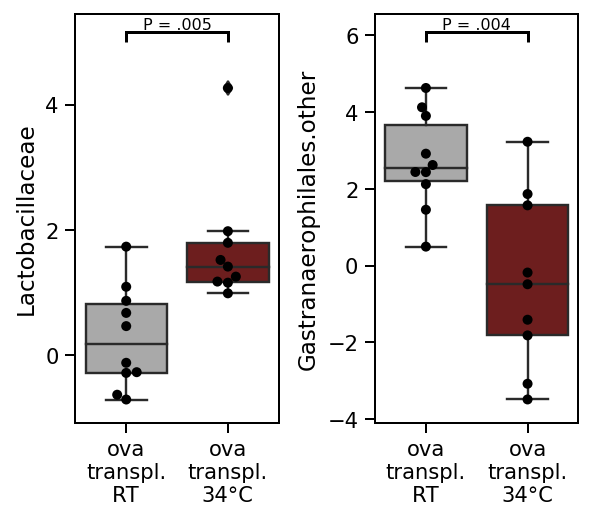

In [23]:
hs.plotting.plotting_Setup(font_scale=1.2)

sns.set_palette(group_colors,desat=0.75)

Pairwise_Sig= StatsF[['we.ep']].T.copy()
Pairwise_Sig.index= [tuple(order)]

VF=hs.Viewpoint(F[sigF],metadata.Group,order,
               Pairwise_Sig= Pairwise_Sig)



axe= multiplot(VF,1,2,sigF,figsize=(4,3.5),sharey=False,pannel_letters=False,sig_labels_params={'font_size':8})
#plt.tight_layout(w_pad=0.1,h_pad=0.1)

for ax in axe:
    ax.set_xticklabels(order)

    
hs.plotting.saveplot('Boxplot_Family',**plt_params)